# PiPCA Demo

PiPCA is a proof of concept Python tool used for exploratory data analysis on experimental LCLS data. This demo will review the functionality of the tool as it exists in its present state.

## Setup and Introductory Analysis

The functionality of PiPCA is accessible through the IPCA class in the btx repository. This tutorial assumes access to SLAC unix servers through the pslogin portal. First we add the relevant repository to our system path using `/cds/home/__PATH_TO_YOUR_DIRECTORY__` instead of the one listed here.

In [1]:
import sys
sys.path.append("/cds/home/h/hepworth/btx-callum")

Next we import all relevant functions from the ipca and psana_interface classes, as well as additional useful libraries.

In [2]:
from btx.interfaces.psana_interface import *
from btx.processing.ipca import *

import numpy as np

In order to run PiPCA on a dataset one must first initialize an instance of the IPCA class, supplying relevant parameters when necessary including the run number, experiment name, and detector type of said data.

In [3]:
exp = 'amo06516' # experiment name
run = 90 #run number
det_type = 'pnccdFront' # detector name, e.g epix10k2M or jungfrau4M

q = 50 # number of principal components to compute and maintain
n = 300 # total number of images to be incorporated into model
m = 50 # size of image batch incorporated in each model update
start_offset = 600 # run index of first image to be incorporated into iPCA model

With a set of example parameters supplied we now instantiate our PiPCA instance.

In [4]:
ipca = IPCA(exp=exp, run=run, det_type=det_type, start_offset=start_offset, num_components=q, batch_size=m, num_images=n)

User supplied parameters are adjusted by the constructor using the method `set_ipca_params` if they are incompatible with the PiPCA algorithm. The finalized parameters can be accessed as follows.

In [5]:
ipca.get_ipca_params()

(0, 50, 50, 1048576)

These values correspond to 
- the number of images incorporated thus far into the PiPCA model
- q, m, n from above

PiPCA is run on the user-specified dataset using the following method.

In [6]:
ipca.run_ipca()

WARNING! INVALID CALIBRATION FILE NAME "new" - missing dash
Factoring 50 samples into 0 sample, 50 component model...
Factoring 50 samples into 50 sample, 50 component model...
Factoring 50 samples into 100 sample, 50 component model...
Factoring 50 samples into 150 sample, 50 component model...
Factoring 50 samples into 200 sample, 50 component model...
Factoring 50 samples into 250 sample, 50 component model...


Provided the sample run is small enough, metrics comparing a run of PiPCA and batch PCA on the supplied data can be computed using the `verify_model_accuracy` method

In [26]:
# ipca.verify_model_accuracy()

We can visualize a de-meaned sample image from a given run using the following example method.

In [14]:
def display_image(idx):
    
    _, _, mu, _ = ipca.get_model()
    _, _, _, d = ipca.get_ipca_params()
    fig, ax = plt.subplots(1)
    
    counter = ipca.psi.counter
    ipca.psi.counter = idx
    img = ipca.get_formatted_images(1, 0, d)
    ipca.psi.counter = counter
    
    img = img - mu
    img = np.reshape(img, ipca.psi.det.shape())
    
    pixel_index_map = retrieve_pixel_index_map(ipca.psi.det.geometry(ipca.psi.run))    
    img = assemble_image_stack_batch(img, pixel_index_map)
    
    vmin = np.min(img.flatten())
    vmax = np.max(img.flatten())
    ax.imshow(img, norm=colors.SymLogNorm(linthresh=1., linscale=1., vmin=0., vmax=vmax))
    plt.show()

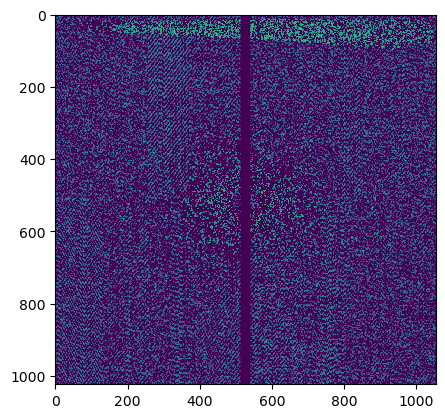

In [27]:
display_image(start_offset)

This clearly isn't a particularly interesting image from our dataset. To find images of importance we can check the stored outliers generated by the `record_loadings` method in `ipca.py`. Let's select outliers selected 2 updates into our run at which point the model would have had time to mature.

In [35]:
outliers = [x for x in (ipca.outliers + m + start_offset) if x > start_offset + 2 * m]
print(outliers)

[709, 732, 795, 796, 803, 813, 816, 819, 824, 834, 837, 838, 844, 845, 851, 853, 855, 856, 871, 876, 878, 880, 881, 882, 886, 887, 890, 892, 893, 899]


Now plotting the first of these images:

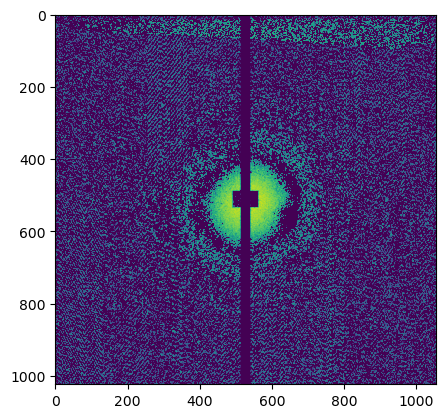

In [53]:
display_image(709)

This sample is clearly more impressive than our previous one (and happens to correspond to a 'hit' on our detector). 

Since all principal components are stored in our ipca object, we can visualize them as follows.

Total mean of PC1: -234.90039959527635
Total stdev of PC1: 7589.919239922712


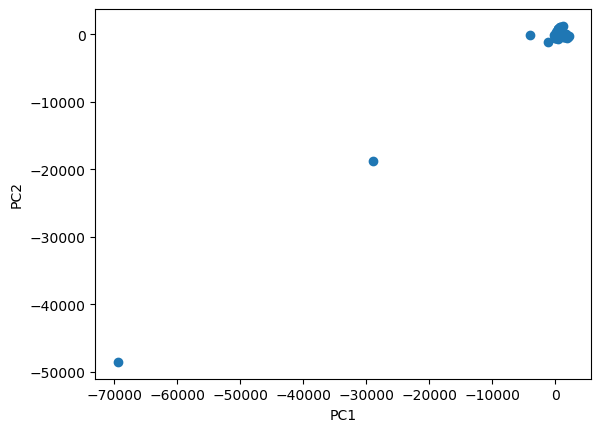

In [45]:
start = 100
end = start + 100

print(f"Total mean of PC1: {np.mean(pcs[0])}")
print(f"Total stdev of PC1: {np.std(pcs[0])}")

pcs = ipca.pc_data[:, start:end]
plt.scatter(pcs[0], pcs[1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In our plot we see a tight grouping relatively close to the origin with a few extreme outliers. We can plot our run indices vs. the first principal components to better visualize our data.

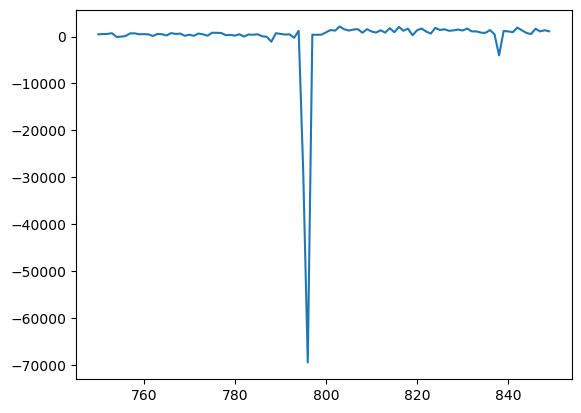

In [47]:
plt.plot(np.arange(start_offset + m + start, start_offset + m + end), pcs[0])
plt.show()

Indeed we see an extreme outlier located at index 796, and a smaller but still significant outlier located at index 838. We will plot the first of these outliers below.

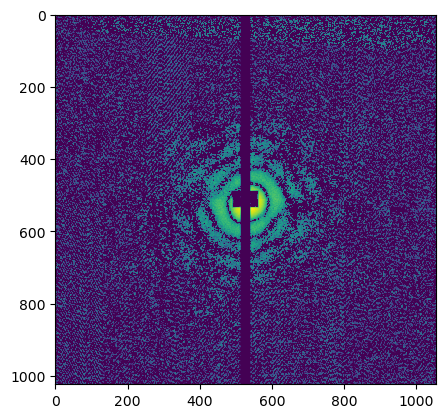

In [54]:
display_image(796)

The current iteration of PiPCA uses naive methods for outlier detection. It is a focus of this project to implement more sophisticated outlier detection methods going forward.

Beyond the basics discussed here, additional functionality of PiPCA includes:
- Priming the model using batch PCA before using iPCA. Can be useful for improving model convergence.
- Running the program in benchmarking mode, which drives input parameters to predictable values for consistency in benchmarking.
- Enabling downsampling using pixel binning to decrease computation overhead. The bin factor is defaulted to 2, but is adjustible.

## CMD use and Parallelization

The saving of generated PiPCA models to disk is currently being added as a feature, so running PiPCA on a run is currently done within Jupyter notebooks. That being said, the command line is still used for gaining access to the SLAC compute cluster for benchmarking purposes. 

The first step in running PiPCA using the command line is to ssh into the psana cluster:

`ssh psana`

Next activate the LCLS python 3 environment.

`source /reg/g/psdm/etc/psconda.sh -py3`

Next add the btx directory containing pipca to your file path (PiPCA can be cloned from here for the time being: https://github.com/calhep/btx/tree/online_pca). You should replace __YOUR_PATH_DIRECTORY_HERE__ with the path to the clone of the above branch:

`export PYTHONPATH='${PYTHONPATH}:/cds/home/__YOUR_DIRECTORY_PATH_HERE__'`

At this stage it would be useful to familiarize oneself with SLURM CMD use at SLAC. This link should prove helpful: https://confluence.slac.stanford.edu/display/SCSPub/Slurm+Batch .

After navigating into the directory containing `ipca.py`, one can view the commands available by entering the following command.

`python ipca.py -h`

To run PiPCA over multiple ranks on the SLAC compute cluster, one must first allocate ranks on a given node. Reserving a subcluster containing 64 ranks on the psanaq node is done as follows.

`salloc -n 64 -p psanaq`

Running over multiple ranks can be done using the `mpirun` command. Refer to the MPI docs for additional information. Now you should be set to run PiPCA on an example dataset!